cross validation
hyper paramereter tuning
grid search cv
randomize search cv more efficient
shap libary feature importance




# BGG Stats

There are a lot of different themes of board games.  Two of the most popular themes are Science Fiction and Fantasy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys
sys.path.append("../data/")

In [2]:
df = pd.read_csv('data/bgg_db_1806.csv')

In [3]:
# don't pass in the whole column because you only need one column
def dummie(column, game_id):
    # create a new dataframe from the column series with game_id as the index
    new_df = pd.DataFrame(column.str.split(', ').tolist(), index=game_id).stack()
    # reset the index
    new_df = new_df.reset_index([0, 'game_id'])
    # convert categorical variable into dummy variables
    new_df = pd.get_dummies(new_df)
    # sum and get rid of duplicate rows
    new_df = new_df.groupby(['game_id']).sum().reset_index()
    # take 0_ out of each column name
    new_df.rename(columns=lambda x: x[2:], inplace=True)
    new_df.rename(columns={'me_id': 'game_id'}, inplace=True)
    
    return new_df

In [4]:
# create dummie 
df_dummie = dummie(df.category, df.game_id)
df_dummie.head()

,game_id,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,...,Travel,Trivia,Video Game Theme,Vietnam War,Wargame,Word Game,World War I,World War II,Zombies,none
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_dummie = dummie(df.category, df.game_id)
dummie_fantasy = df_dummie[['game_id', 'Fantasy']]
dummie_scifi = df_dummie[['game_id', 'Science Fiction']]

In [6]:
dummie_fantasy = dummie_fantasy[dummie_fantasy['Fantasy'] > 0]
f_game_id = dummie_fantasy.game_id.values

dummie_scifi = dummie_scifi[dummie_scifi['Science Fiction'] > 0]
s_game_id = dummie_scifi.game_id.values

In [7]:
df_fantasy = df.loc[df['game_id'].isin(f_game_id)]
fantasy_avg = df_fantasy['avg_rating']
fantasy_geek = df_fantasy['geek_rating']

df_scifi = df.loc[df['game_id'].isin(s_game_id)]
scifi_avg = df_scifi['avg_rating']
scifi_geek = df_scifi['geek_rating']

In [11]:
print(df_fantasy['avg_rating'].mean())
print(df_scifi['avg_rating'].mean())

7.050210719999991
7.106047526881722


In [12]:
# DataQuest bootstrap functions
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, len(data)))

def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

In [13]:
# Bootstrap 10,000 replicates of the mean()
bs_mean_fantasy_avg = draw_bs_reps(fantasy_avg, np.mean, 10000)
bs_mean_fantasy_geek = draw_bs_reps(fantasy_geek, np.mean, 10000)

bs_mean_scifi_avg = draw_bs_reps(scifi_avg, np.mean, 10000)
bs_mean_scifi_geek = draw_bs_reps(scifi_geek, np.mean, 10000)

In [14]:
bs_mean_diff_avg = bs_mean_fantasy_avg - bs_mean_scifi_avg
bs_mean_diff_geek = bs_mean_fantasy_geek - bs_mean_scifi_geek

conf_int_95_avg = np.percentile(bs_mean_diff_avg, [2.5, 97.5])
conf_int_95_geek = np.percentile(bs_mean_diff_geek, [2.5, 97.5])

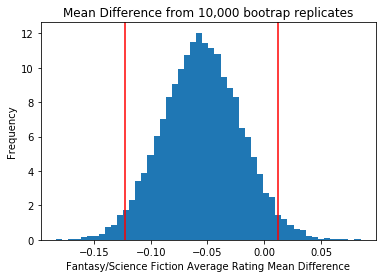

In [17]:
plt.hist(bs_mean_diff_avg, density=True, bins=50)
plt.axvline(x=conf_int_95_avg[0], color='r')
plt.axvline(x=conf_int_95_avg[1], color='r')
plt.xlabel('Fantasy/Science Fiction Average Rating Mean Difference')
plt.ylabel('Frequency')
plt.title('Mean Difference from 10,000 bootrap replicates');

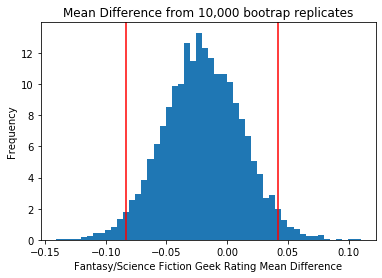

In [44]:
_ = plt.hist(bs_mean_diff_geek, density=True, bins=50)
_ = plt.axvline(x=conf_int_95_geek[0], color='r')
_ = plt.axvline(x=conf_int_95_geek[1], color='r')
_ = plt.xlabel('Fantasy/Science Fiction Geek Rating Mean Difference')
_ = plt.ylabel('Frequency')
_ = plt.title('Mean Difference from 10,000 bootrap replicates')

In [45]:
def shifted_arrays(whole_data, data, func):
    return(data * func(whole_data) / func(data))

In [46]:
concate_data_avg = np.concatenate((fantasy_avg, scifi_avg))
concate_data_geek = np.concatenate((fantasy_geek, scifi_geek))

In [47]:
shifted_fantasy_avg = shifted_arrays(concate_data_avg, fantasy_avg, np.mean)
shifted_fantasy_geek = shifted_arrays(concate_data_geek, fantasy_geek, np.mean)

shifted_scifi_avg = shifted_arrays(concate_data_avg, scifi_avg, np.mean)
shifted_scifi_geek = shifted_arrays(concate_data_geek, scifi_geek, np.mean)

In [48]:
bs_mean_shifted_fantasy_avg = draw_bs_reps(shifted_fantasy_avg, np.mean, 10000)
bs_mean_shifted_fantasy_geek = draw_bs_reps(shifted_fantasy_geek, np.mean, 10000)

bs_mean_shifted_scifi_avg = draw_bs_reps(shifted_scifi_avg, np.mean, 10000)
bs_mean_shifted_scifi_geek = draw_bs_reps(shifted_scifi_geek, np.mean, 10000)

In [49]:
mean_diff_shifted_avg = bs_mean_shifted_fantasy_avg - bs_mean_shifted_scifi_avg
mean_diff_shifted_geek = bs_mean_shifted_fantasy_geek - bs_mean_shifted_scifi_geek

measured_mean_diff_avg = np.mean(fantasy_avg) - np.mean(scifi_avg)
measured_mean_diff_geek = np.mean(fantasy_geek) - np.mean(scifi_geek)

In [50]:
# Compute and print p-value
def find_p(bs_diff, measured_diff):
    return(np.sum(bs_diff >= measured_diff) / len(bs_diff))

In [51]:
p_avg = find_p(mean_diff_shifted_avg, measured_mean_diff_avg)
p_geek = find_p(mean_diff_shifted_geek, measured_mean_diff_geek)

print(p_avg, p_geek)

0.9502 0.7315


In [19]:
df_2017 = df[df['year'] == 2017]
df_2004 = df[df['year'] == 2004]

In [20]:
df_2004.describe()

,rank,game_id,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,age,owned,weight
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.0,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,2468.365517,11800.255172,2.151724,4.793103,124.931034,88.931034,124.931034,2004.0,6.782383,6.111419,3241.220690,10.475862,4282.282759,2.385308
std,1486.847176,3440.729168,0.604739,2.434978,378.227769,91.296956,378.227769,0.0,0.550939,0.502882,7196.498154,2.315656,9060.670893,0.866412
min,29.000000,2651.000000,1.000000,2.000000,15.000000,0.000000,15.000000,2004.0,5.792010,5.642810,90.000000,0.000000,158.000000,1.043700
25%,1099.000000,9804.000000,2.000000,4.000000,30.000000,30.000000,30.000000,2004.0,6.309750,5.728370,404.000000,9.000000,697.000000,1.767400
50%,2565.000000,11229.000000,2.000000,4.000000,60.000000,50.000000,60.000000,2004.0,6.726960,5.893770,817.000000,10.000000,1445.000000,2.315800
75%,3735.000000,13071.000000,2.000000,6.000000,120.000000,120.000000,120.000000,2004.0,7.159620,6.365970,2632.000000,12.000000,3783.000000,3.035100
max,4933.000000,39332.000000,5.000000,16.000000,4500.000000,480.000000,4500.000000,2004.0,8.261290,7.827220,55115.000000,16.000000,70909.000000,4.366700


In [15]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, len(data)))

In [13]:
def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

In [10]:
# Generate Shifted arrays
def shifted_arrays(data, stat_data, stat):
    return(data - stat(data) + stat_data)

In [11]:
# A two sample boostrap hypothesis for difference
def bootstrap_differences(data_1, data_2, stat, size=1):
    # Concatenate forces: forces_concat
    data_concat = np.concatenate((data_1, data_2))
    
    # Compute stat of all data
    stat_data = stat(data_concat)
    
    # Generate Shifted arrays
    data_1_shifted = shifted_arrays(data_1, stat_data, stat)
    data_2_shifted = shifted_arrays(data_2, stat_data, stat)

    # Compute size bootstrap replicates from shifted arrays
    bs_data_1 = draw_bs_reps(data_1_shifted, stat, size)
    bs_data_2 = draw_bs_reps(data_2_shifted, stat, size)
    
    # Get replicates of difference of stat
    bs_replicated = bs_data_1 - bs_data_2
    
    return bs_replicated

In [19]:
geek_rating_2004 = df_2004['geek_rating']
geek_rating_2017 = df_2017['geek_rating']

avg_rating_2004 = df_2004['geek_rating']
avg_rating_2017 = df_2017['geek_rating']

In [20]:
bs_geek_rating_mean = bootstrap_differences(geek_rating_2004, geek_rating_2017, np.mean, 10000)
bs_avg_rating_mean = bootstrap_differences(avg_rating_2004, avg_rating_2017, np.mean, 10000)

In [17]:
# Compute difference of stat impact data from experiment
def diff_of_stat(data_1, data_2, stat):
    return stat(data_1) - stat(data_2)

In [18]:
# Compute and print p-value
def find_p(data, diff_stat):
    return(np.sum(data >= diff_stat) / len(data))

In [23]:
emp_diff_mean_geek = diff_of_stat(geek_rating_2004, geek_rating_2017, np.mean)
geek_p = find_p(bs_geek_rating_mean, emp_diff_mean_geek)
geek_p

0.3127

In [24]:
emp_diff_mean_avg = diff_of_stat(avg_rating_2004, avg_rating_2017, np.mean)
avg_p = find_p(bs_avg_rating_mean, emp_diff_mean_avg)
avg_p

0.3184

In [25]:
geek_boot_mean_2004 = draw_bs_reps(geek_rating_2004, np.mean, 10000)
geek_boot_mean_2017 = draw_bs_reps(geek_rating_2017, np.mean, 10000)

In [27]:
mean_diff_geek = geek_boot_mean_2004 - geek_boot_mean_2017

In [28]:
gbm_2004 = np.mean(geek_boot_mean_2004)
gbm_2017 = np.mean(geek_boot_mean_2017)
mdg = np.mean(mean_diff_geek)

Text(0.5, 0, 'Mean Charges')

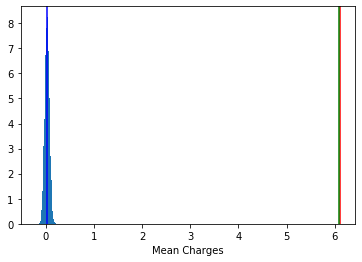

In [31]:
plt.hist(mean_diff_geek, density=True, bins=50)
plt.axvline(x=gbm_2004, color='r')
plt.axvline(x=gbm_2017, color='g')
plt.axvline(x=mdg, color='b')
plt.xlabel('Mean Charges')